In [ ]:
# Model architecture inspired by Z. Hameed and B. Garcia-Zapirain, "Sentiment classification using a single-layered BiLSTM model", IEEE Access, vol. 8, pp. 73992-74001, 2020.
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import re

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Bidirectional, LSTM, Input, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate

from keras.layers.embeddings import Embedding

In [ ]:
# Get glove.6B.300d.txt beforehand

embeddings_index = {}
with open("LOCAL_PATH_TO_glove.6B.300d.txt") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
df = pd.read_csv('LOCAL_PATH_TO_DATASET')
df = df[['Emotion','Statement']]
display(df.head())

,Emotion,Statement
0,guilt,Once when I was in the cell group (religious a...
1,shame,When I overslept for the second time on the da...
2,shame,I had not punched a ticket in the bus because ...
3,disgust,When a man spoke very sexistly in the company ...
4,shame,About a dozen girls laughed at me and I was su...


In [ ]:
def process_text(document):
     
    # Remove extra white space from text
    document = re.sub(r'\s+', ' ', document, flags=re.I)
         
    # Remove all the special characters from text
    document = re.sub(r'\W', ' ', str(document))

    return document

In [ ]:
from tqdm import tqdm

df['preprocessedStatement'] = df.Statement.apply(process_text)
display(df.head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,Emotion,Statement,preprocessedStatement
0,guilt,Once when I was in the cell group (religious a...,"[once, when, was, the, cell, group, religious,..."
1,shame,When I overslept for the second time on the da...,"[when, overslept, for, the, second, time, the,..."
2,shame,I had not punched a ticket in the bus because ...,"[had, not, punched, ticket, the, bus, because,..."
3,disgust,When a man spoke very sexistly in the company ...,"[when, man, spoke, very, sexistly, the, compan..."
4,shame,About a dozen girls laughed at me and I was su...,"[about, dozen, girls, laughed, and, was, sure,..."


In [ ]:
max_length = df.preprocessedStatement.apply(lambda x: len(x.split())).max()

t = Tokenizer()
t.fit_on_texts(df['preprocessedStatement'] )
vocab_size = len(t.word_index) + 1
encoded_tweets = t.texts_to_sequences(df['preprocessedStatement'] )
X = pad_sequences(encoded_tweets, maxlen=max_length, padding='post')

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
# Encode labels in column 'Emotion'. 
df['Emotion'] = le.fit_transform(df['Emotion']) 
y = df.pop('Emotion')
y_new = tf.keras.utils.to_categorical(y, num_classes=7)
print(y_new)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
list(le.inverse_transform([0,1,2,3,4,5,6]))

ValueError: ignored

In [ ]:
y.value_counts()

3    12885
5     1823
4     1150
0     1022
1      353
2      174
Name: Emotion, dtype: int64

In [ ]:
# 2 options to handle imbalanced dataset: class_weight or focal loss
class_weight = {0: 6, 1: 22, 2: 30, 3: 1, 4: 2, 5: 7, 6: 5}

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y_new, test_size=0.05, stratify=y_new)

x_val = x_train[:100]
y_val = y_train[:100]
x_train = x_train[100:]
y_train = y_train[100:]

In [ ]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=3)
input_layer = Input(shape=(max_length), )
x = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)(input_layer)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x_a = GlobalMaxPool1D()(x)
x_b = GlobalAveragePooling1D()(x)
x = concatenate([x_a,x_b])
x = Dense(64, activation="relu")(x)
x = Dense(7, activation='softmax')(x)
model_glove = Model(inputs=input_layer, outputs=x)
model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #use if you are using class_weight
#model_glove.compile(loss=focal_loss(alpha=1), optimizer='adam', metrics=['accuracy']) #use if you are using focal loss
model_glove.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 231)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 231, 300)     3194400     input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 231, 64)      85248       embedding_1[0][0]                
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 64)           0           bidirectional_1[0][0]            
____________________________________________________________________________________________

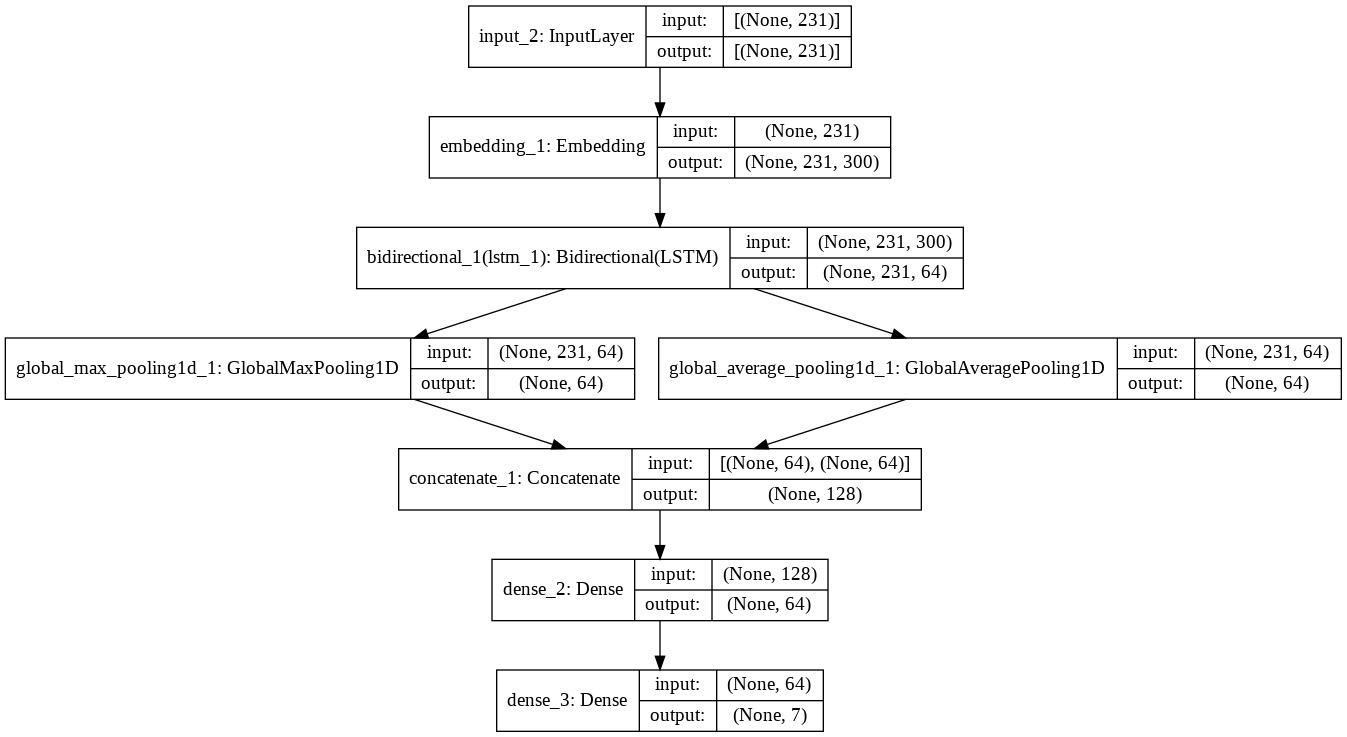

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_glove,show_shapes= True)

In [ ]:
model_glove.fit(x_train, y_train, epochs = 20, validation_data=(x_val, y_val), callbacks=[callback]) #insert class_weight=class_weight if using class_weight

Epoch 1/20
514/514 [==============================] - 47s 82ms/step - loss: 0.3910 - accuracy: 0.7842 - val_loss: 0.2771 - val_accuracy: 0.8500
Epoch 2/20
514/514 [==============================] - 41s 80ms/step - loss: 0.2683 - accuracy: 0.8363 - val_loss: 0.2529 - val_accuracy: 0.8700
Epoch 3/20
514/514 [==============================] - 41s 79ms/step - loss: 0.2281 - accuracy: 0.8553 - val_loss: 0.2219 - val_accuracy: 0.8900
Epoch 4/20
514/514 [==============================] - 41s 79ms/step - loss: 0.1945 - accuracy: 0.8773 - val_loss: 0.2221 - val_accuracy: 0.8900
Epoch 5/20
514/514 [==============================] - 41s 79ms/step - loss: 0.1639 - accuracy: 0.8919 - val_loss: 0.2285 - val_accuracy: 0.9000
Epoch 6/20
514/514 [==============================] - 41s 79ms/step - loss: 0.1366 - accuracy: 0.9059 - val_loss: 0.2313 - val_accuracy: 0.9100
Epoch 7/20
514/514 [==============================] - 41s 79ms/step - loss: 0.1153 - accuracy: 0.9183 - val_loss: 0.2331 - val_accuracy:

In [ ]:
y_pred = model_glove.predict(x_test)

In [ ]:
y_pred_clean = np.argmax(y_pred, 1)
y_test_clean = np.argmax(y_test, 1)

In [ ]:
print(classification_report(y_test_clean, y_pred_clean))

              precision    recall  f1-score   support

           0       0.61      0.39      0.48        51
           1       0.53      0.50      0.51        18
           2       1.00      0.67      0.80         9
           3       0.93      0.96      0.94       645
           4       0.70      0.68      0.69        57
           5       0.70      0.70      0.70        91

    accuracy                           0.87       871
   macro avg       0.74      0.65      0.69       871
weighted avg       0.86      0.87      0.86       871

